In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
def load_stock_data(stock_code):
    """Load daily stock data for a given stock code."""
    file_path = f'../data/raw/daily/{stock_code}.csv'
    if os.path.exists(file_path):
        stock_data = pd.read_csv(file_path)
        stock_data['timestamp'] = pd.to_datetime(stock_data['timestamp'])
        stock_data.set_index('timestamp', inplace=True)
        return stock_data
    else:
        print(f"File for stock code {stock_code} not found.")
        return None

# Load data for a specific stock code
stock_code = 'AALI'  # Stock code from DaftarSaham.csv
stock_data = load_stock_data(stock_code)

# Display the first few rows of the stock data
if stock_data is not None:
    stock_data.head()

In [3]:
def preprocess_data(data):
    """Preprocess the data for LSTM."""
    # Use 'close' as the target variable
    data = data[['close']]
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

def create_dataset(data, time_step=1):
    """Create dataset for LSTM."""
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Preprocess the data
if stock_data is not None:
    scaled_data, scaler = preprocess_data(stock_data)

    # Create dataset
    time_step = 60  # Number of previous days to consider
    X, y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}, {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, {y_test.shape}')

Training data shape: (4487, 60, 1), (4487,)
Testing data shape: (1122, 60, 1), (1122,)


In [5]:
def create_model(input_shape):
    """Create and compile the LSTM model."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model
model = create_model((X_train.shape[1], 1))

c:\Users\wilda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Train the model
epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0195 - val_loss: 8.1314e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0023 - val_loss: 7.2830e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0020 - val_loss: 6.8958e-04
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0021 - val_loss: 5.6159e-04
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0017 - val_loss: 5.7025e-04
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0016 - val_loss: 6.4682e-04
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0015 - val_loss: 6.6643e-04
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0013 - val_loss: 4.7968e-04
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0013 - val_loss: 4.5751e-04
Epoch

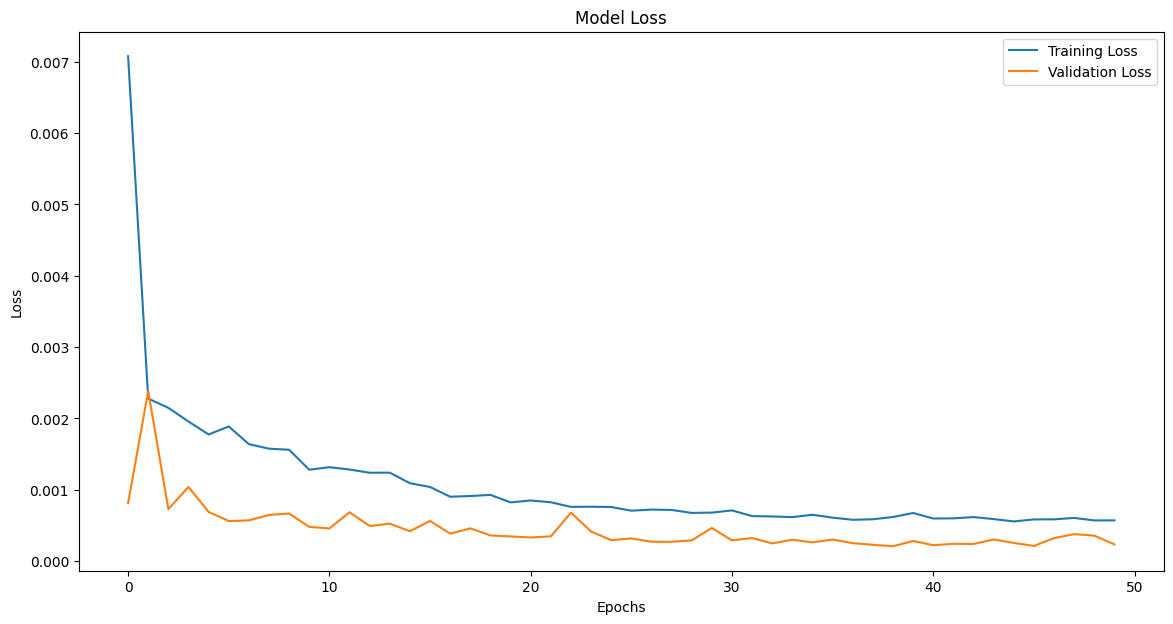

In [7]:
# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Save the model
model.save('lstm_model.h5')
print("Model saved as 'lstm_model.h5'")

Model saved as 'lstm_model.h5'
